In [1]:
# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Imports, as always...

import pandas as pd
import numpy as np

# PyTorch (+ Geometric)
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv

from torch_kmeans import KMeans

# Visualisation.
import matplotlib.pyplot as plt
import seaborn as sns

# Script imports.
from scripts.training import train, evaluate
from scripts.utils import produce_reduced_embeddings, plot_reduced_embeddings
from scripts import models

In [3]:
# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [4]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Set RNG.
_ = torch.manual_seed(42)

In [6]:
# Dataset.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(
    root='./',
    name='CiteSeer',
    split='public',
    transform=torch_geometric.transforms.GCNNorm()
  )

print(dataset.data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


# (Learnable) Weighted Residual Connections

This notebook will develop a GNN with weighted residual connections, which is proposed by [Liu et al. (2024)](https://ieeexplore.ieee.org/document/10540641) to realise *sparse aggregation* (and thus alleviate semantic over-smoothing).

Formally, they  give the expression
$$
\begin{split}
H^{(l+1)}&=\mathrm{GNN}^{(l)}(\hat{A},H^{(l)})=\Xi^{(l)}\sigma(f(\hat{A},H^{(l)}))+(I_n-\Xi^{(l)})H^{(l)}\\ 
\text{with}\quad\Xi_{i,i}^{(l)}&=\Theta^{(l)}\cdot\Phi_i^{(l)}\cdot\Psi_i^{(l)}\in[0,1]\ .
\end{split}
$$

These control parameters $\Theta^{(l)}$, $\Phi_i^{(l)}$, and $\Psi_i^{(l)}$ are painstakingly computed from statistics about the graph, which includes an expensive and repetitive clustering operation. Before we go through the hassle of implementing them, I wonder whether directly learning the $\Xi_{i,i}^{(l)}$ wouldn't do the trick. This simplification of [Liu et al. (2024)](https://ieeexplore.ieee.org/document/10540641) would certainly resolve their fundamental limitation of computational expense, but it might not be direct enough to resolve the over-smoothing; we shall find out!

Instead of waiting for some given $L_0$ to start residual connections, we will arbitrarily choose to apply residual connections only between hidden layers.

## Free Learning

In [7]:
# Define a set of GCN models of different depths.
model_depths = [1, 5, 10, 20]
n_nodes = len(dataset.data.x)
GCNWithLWRC_models = [
    models.BackboneModel(
        residual_method=models.FreeRC,
        aggregation_function=GCNConv,
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=64,
        n_classes=dataset.num_classes,
        n_layers=depth,
        dropout_ratio=.1,
        act_fn=F.relu
    )
    for depth in model_depths
]

# Train them.
GCNWithLWRC_models_stats = {}
for model in GCNWithLWRC_models:
    GCNWithLWRC_models_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=200,
        max_patience=20,
        lr=5e-3,
        progress_bar=True,
        verbose=False
    )

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_GCNWithLWRC_model = {
    model.n_layers : produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in GCNWithLWRC_models
}

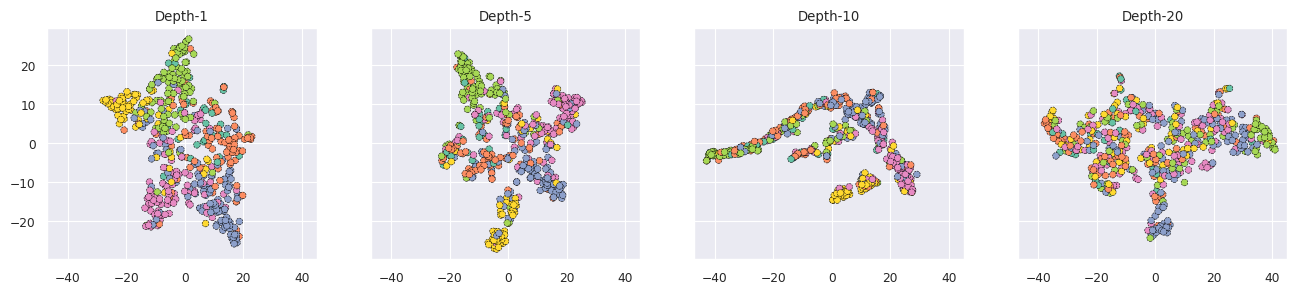

In [9]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_GCNWithLWRC_model)
    
# Save figure.
#plt.savefig('./figures/LWRC-GCN/convergence_by_depth.pdf', bbox_inches='tight')

## Cluster-keeping

In [34]:
n_nodes = len(dataset.data.x)
cluster_model = models.BackboneModel(
    residual_method= models.ClusterKeepingRC,
    aggregation_function=GCNConv,
    n_nodes=n_nodes,
    input_dim=dataset.num_features,
    hid_dim=64,
    n_classes=dataset.num_classes,
    n_layers=10,
    dropout_ratio=.1,
    L_0=2,
    act_fn=F.relu
)

_ = train(
    cluster_model,
    dataset.data,
    device,
    epochs=100,
    max_patience=20,
    lr=1e-3,
    progress_bar=True,
    verbose=True,
    print_interval=5
)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 005: train loss - 1.789, train acc - 0.225, val loss - 1.790, val acc - 0.220
Epoch 010: train loss - 1.780, train acc - 0.308, val loss - 1.785, val acc - 0.284
Epoch 015: train loss - 1.740, train acc - 0.317, val loss - 1.757, val acc - 0.338
Epoch 020: train loss - 1.595, train acc - 0.300, val loss - 1.661, val acc - 0.268
Epoch 025: train loss - 1.411, train acc - 0.425, val loss - 1.545, val acc - 0.356
Epoch 030: train loss - 1.251, train acc - 0.450, val loss - 1.470, val acc - 0.424
Epoch 035: train loss - 1.175, train acc - 0.492, val loss - 1.486, val acc - 0.474
Epoch 040: train loss - 1.105, train acc - 0.517, val loss - 1.533, val acc - 0.480
Epoch 045: train loss - 1.053, train acc - 0.492, val loss - 1.578, val acc - 0.434
Epoch 050: train loss - 0.947, train acc - 0.600, val loss - 1.568, val acc - 0.450
Epoch 055: train loss - 0.796, train acc - 0.633, val loss - 1.517, val acc - 0.448
Epoch 060: train loss - 0.612, train acc - 0.875, val loss - 1.528, val acc 

In [35]:
print('Global convergence weights after training:')
for i, layer in enumerate(cluster_model.layers):
    if type(layer) == models.ClusterKeepingRC:
        print(f'Layer {i}: dist_0/dist_l = {layer.dist_0:.3f}/{layer.dist_l:.3f} = {layer.dist_0/layer.dist_l:.3f}, theta = {layer.theta:.3f}')

Global convergence weights after training:
Layer 2: dist_0/dist_l = 8.927/8.927 = 1.000, theta = 1.000
Layer 3: dist_0/dist_l = 8.927/16.618 = 0.537, theta = 0.537
Layer 4: dist_0/dist_l = 8.927/21.739 = 0.411, theta = 0.411
Layer 5: dist_0/dist_l = 8.927/23.334 = 0.383, theta = 0.383
Layer 6: dist_0/dist_l = 8.927/24.001 = 0.372, theta = 0.372
Layer 7: dist_0/dist_l = 8.927/24.921 = 0.358, theta = 0.358
Layer 8: dist_0/dist_l = 8.927/25.739 = 0.347, theta = 0.347


In [36]:
reduced_embeddings = produce_reduced_embeddings(cluster_model, dataset.data, dataset.data.val_mask)

Text(0, 0.5, '')

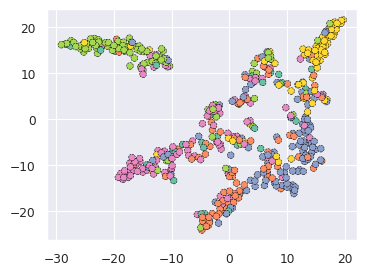

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# Plot the data.
sns.scatterplot(
    x=reduced_embeddings['dimension 1'],
    y=reduced_embeddings['dimension 2'],
    hue=reduced_embeddings['labels'],
    palette='Set2',
    linestyle='--',
    edgecolors='k',
    ax=ax
)
ax.legend([], [], frameon=False)
ax.set_xlabel('')
ax.set_ylabel('')

# Baseline GCN

In [13]:
# Define a set of GCN models of different depths.
model_depths = [1, 5, 10, 20]
GCN_models = [
    models.GCN(
        input_dim=dataset.num_features,
        hid_dim=64,
        n_classes=dataset.num_classes,
        n_layers=depth,
    )
    for depth in model_depths
]

# Train them.
GCN_models_stats = {}
for model in GCN_models:
    GCN_models_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        epochs=200,
        max_patience=20,
        lr=5e-3,
        progress_bar=True,
        verbose=False
    )

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

In [19]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_GCN_model = {
    model.n_layers : produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in GCN_models
}

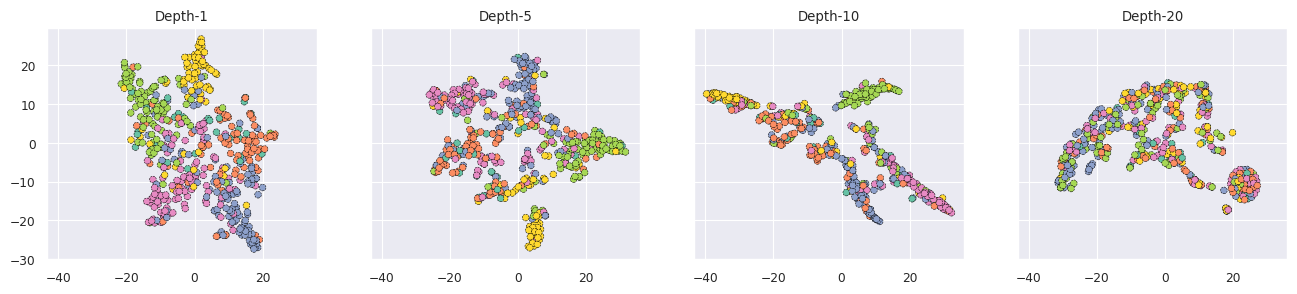

In [20]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_GCN_model)
    
# Save figure.
#plt.savefig('./figures/GCN/convergence_by_depth.pdf', bbox_inches='tight')

# Training Curves

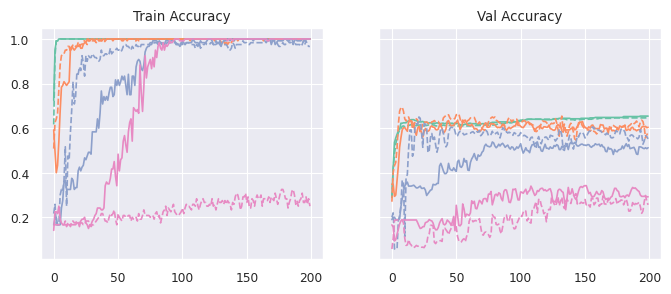

In [25]:
# Side-by-side train and validation curves. No testing at this stage.
# Losses on the top row, accuracies on the bottom.
def plot_curves():
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all', sharey='row')
    
    # Colours for plotting.
    colours = sns.color_palette('Set2', n_colors=len(GCN_models_stats))
    
    keys = GCNWithLWRC_models_stats.keys()
    for i, key in enumerate(keys):
        # Pull the stats out of the dictionaries.
        LWRC_accs_train = GCNWithLWRC_models_stats[key]['train_acc']
        LWRC_losses_train = GCNWithLWRC_models_stats[key]['train_loss']
        GCN_accs_train = GCN_models_stats[key]['train_acc']
        GCN_losses_train = GCN_models_stats[key]['train_loss']
        LWRC_accs_val = GCNWithLWRC_models_stats[key]['val_acc']
        LWRC_losses_val = GCNWithLWRC_models_stats[key]['val_loss']
        GCN_accs_val = GCN_models_stats[key]['val_acc']
        GCN_losses_val = GCN_models_stats[key]['val_loss']
        
        # Plot the train accuracies.
        sns.lineplot(
            data=LWRC_accs_train,
            ax=axes[0],
            
            # Beautification.
            color=colours[i],
        )
        
        sns.lineplot(
            data=GCN_accs_train,
            ax=axes[0],
            
            # Beautification.
            color=colours[i],
            linestyle='--'
        )
        
        # Plot the train losses.
        #sns.lineplot(
        #    data=LWRC_losses_train,
        #    ax=axes[1][0],
        #    
        #    # Beautification.
        #    color=colours[i],
        #)
        
        #sns.lineplot(
        #    data=GCN_losses_train,
        #    ax=axes[1][0],
        #    
        #    # Beautification.
        #    color=colours[i],
        #    linestyle='--'
        #)
        
        # Plot the val accuracies.
        sns.lineplot(
            data=LWRC_accs_val,
            ax=axes[1],
            
            # Beautification.
            color=colours[i],
        )
        
        sns.lineplot(
            data=GCN_accs_val,
            ax=axes[1],
            
            # Beautification.
            color=colours[i],
            linestyle='--'
        )
        
        # Plot the val losses.
        #sns.lineplot(
        #    data=LWRC_losses_val,
        #    ax=axes[1][1],
        #    
        #    # Beautification.
        #    color=colours[i],
        #)
        
        #sns.lineplot(
        #    data=GCN_losses_val,
        #    ax=axes[1][1],
        #    
        #    # Beautification.
        #    color=colours[i],
        #    linestyle='--'
        #)
    
    axes[0].set_title('Train Accuracy')
    axes[1].set_title('Val Accuracy')
    #axes[1][0].set_title('Train Loss')
    #axes[1][1].set_title('Val Loss')
        
plot_curves()